<div align="center">
  <a href="https://www.davivienda.com/wps/portal/personas/nuevo">
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" alt="Logo" width="300" height="100">
  </a>

  <h2 align="center">Prueba Técnica Davivienda aDNE - Especialista I</h2>
  <h2 align="center">Notebook de Implementación Clasificador de Imágenes Con Contenido/Sin Contenido</h2>
  <h4 align="center">Luvan Tabares</h4>
    
***

  <p align="left">
    Se requiere el desarrollo de un modelo con la capacidad de identificar si un documento contiene información relevante o no. En esta clasificación, se consideran como documentos sin contenido aquellos que solo presentan un pie de página o están membreteados, pero carecen de información significativa. Para esta tarea, se dispone de una carpeta con 100 imágenes con contenido y 147 imágenes sin contenido. 
    
  <p align="left">
    Se propone aumentar el conjunto de datos buscando imágenes adicionales en datasets públicos, con el objetivo de alcanzar un total de 1000 imágenes, distribuidas equitativamente en 500 con contenido y 500 sin contenido. Para lograrlo, se utilizarán técnicas preliminares de identificación de imágenes sin contenido, tales como el análisis del peso de la imagen y el valor del laplaciano. Estos parámetros deberán ser ajustados para cada dataset con el fin de asegurar una correcta extracción de las imágenes sin contenido. 
    
  <p align="left">
    Una vez aumentado el dataset, se procederá a entrenar un modelo utilizando TensorFlow y una red neuronal convolucional (CNN). Los datos se dividirán en conjuntos de entrenamiento y validación. Posteriormente, se extraerá la matriz de confusión únicamente de los datos suministrados originalmente, con el fin de evaluar el rendimiento del modelo.    
    
  </p>
</div>

## Tabla de contenidos

1. [Instalación de librerías y llamado de librerías](#first1) <br />
2. [Preparación de datos](#second1) <br />
  2.1. [Tobacco 800 Dataset](#second1-1) <br />
  2.2. [Tobacco3482 Dataset](#second1-2) <br />
  2.3. [RVL-CDIP Dataset](#second1-3) <br />
  2.4. [Organización del nuevo dataset](#second1-4) <br />
3. [Procesamiento de las imágenes](#third1) <br />
4. [Definición del modelo](#fourth1) <br />
5. [Entrenamiento](#fifth1) <br />



## 1. Librerias a instalar <a id="first1"></a>

In [97]:
!pip install -r requirements.txt

## Cargar las librerías necesarias

In [3]:
import os
from PIL import Image, ImageOps
import statistics
import shutil
import cv2
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import random

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-07-18 16:07:46.755486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 16:07:46.766750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 16:07:46.770147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 16:07:46.779387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 16:07:47.359844: W tensorflow/compiler/tf2

## 2. Revisión de la data suministrada <a id="second1"></a>

### Se revisó la información suministrada para la prueba, esta cuenta con 100 imágenes con contenido y 147 imágenes sin contenido. En mi experiencia esta cantidad de datos es muy poca por lo que se recomienda buscar datasets externos para robustecer la base de entrenamiento. Para dicho proceso se utilizará las siguientes bases:

1. Tobacco 800 Dataset, Este dataset tiene 1292 imágenes, pero las imágenes son de fondo negro y letras blancas, toca realizarle un preprocesamiento. (https://www.kaggle.com/datasets/sprytte/tobacco-800-dataset?resource=download)
2. Tobacco3482 Dataset, Este dataset tiene 3492 imágenes, en este caso las imágenes vienen en jpg, ya que la data original viene en png mejor normalizo todo a png. (https://www.kaggle.com/datasets/patrickaudriaz/tobacco3482jpg)
3. The RVL-CDIP Dataset test, Este dataset tiene 39997 imáagenes, para este dataset las imágenes vienen en formato tif, por lo que se deben convertir a png. (https://www.kaggle.com/datasets/pdavpoojan/the-rvlcdip-dataset-test)

### Debido a que con estos datasets se procesarían 44781 imágenes (7.0 GB en peso) se reducirá la data entregada a la solamente utilizada (imágenes sin contenido extraídas) y agregando para cada dataset la misma cantidad de imágenes con contenido al azar

### Iniciar extrayendo data para test

In [99]:
### Inicialmente creamos una carpeta aislada con data para test.

def move_random_files(source_folder, destination_folder, num_files, seed):
    """
    Moves a specified number of random files from a source folder to a destination folder.

    This function first checks if the destination folder exists, creating it if necessary.
    It then lists all files in the source folder, selects a random sample of files based on the specified number,
    and moves each selected file to the destination folder. The selection process is seeded for reproducibility.

    Args:
        source_folder (str): The path to the source folder from which files will be moved.
        destination_folder (str): The path to the destination folder where files will be moved to.
        num_files (int): The number of files to randomly select and move.
        seed (int): The seed value for the random number generator to ensure reproducibility.

    Returns:
        None
    """
    # Check if the destination folder exists, create if not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Seed the random number generator for reproducibility
    random.seed(seed)

    # List all files in the source folder
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
    
    # Select a random sample of files, ensuring not to exceed the total number of available files
    files_to_move = random.sample(files, min(num_files, len(files)))
    
    # Move each selected file to the destination folder
    for file_name in files_to_move:
        source_path = os.path.join(source_folder, file_name)  # Define the source path
        destination_path = os.path.join(destination_folder, file_name)  # Define the destination path
        shutil.move(source_path, destination_path)  # Move the file
        print(f"Moved: {file_name}")  # Print confirmation for each moved file


# Define the source and destination folders for "docs_con_contenido"
source_folder_con = 'data_original/Imagenes/docs_con_contenido'
destination_folder_con = 'data_test/docs_con_contenido'

# Define the source and destination folders for "docs_sin_contenido"
source_folder_sin = 'data_original/Imagenes/docs_sin_contenido'
destination_folder_sin = 'data_test/docs_sin_contenido'

num_files_to_move = 50
random_seed = 1

# Move 50 random files from each source folder to the respective destination folder
move_random_files(source_folder_con, destination_folder_con, num_files_to_move, random_seed)
move_random_files(source_folder_sin, destination_folder_sin, num_files_to_move, random_seed)


Moved: page-63.png
Moved: page-113.png
Moved: page-134.png
Moved: page-144.png
Moved: page-81.png
Moved: page-122.png
Moved: page-66.png
Moved: page-53.png
Moved: page-27.png
Moved: page-149.png
Moved: page-117.png
Moved: page-124.png
Moved: page-84.png
Moved: page-32.png
Moved: page-46.png
Moved: page-80.png
Moved: page-45.png
Moved: page-89.png
Moved: page-145.png
Moved: page-18.png
Moved: page-139.png
Moved: page-42.png
Moved: page-140.png
Moved: page-41.png
Moved: page-118.png
Moved: page-39.png
Moved: page-65.png
Moved: page-92.png
Moved: page-93.png
Moved: page-47.png
Moved: page-35.png
Moved: page-16.png
Moved: page-123.png
Moved: page-51.png
Moved: page-9.png
Moved: page-138.png
Moved: page-109.png
Moved: page-8.png
Moved: page-52.png
Moved: page-150.png
Moved: page-68.png
Moved: page-87.png
Moved: page-13.png
Moved: page-77.png
Moved: page-15.png
Moved: page-55.png
Moved: page-25.png
Moved: page-7.png
Moved: page-114.png
Moved: page-74.png
Moved: page-221.png
Moved: page-227.p

### 2.1 Extracción de imágenes sin contenido para Tobacco 800 Dataset <a id="second1-1"></a>

### Como este dataset tiene las imágenes con fondo negro y letras blancas se deben invertir todas las imágenes

In [100]:
### Función para invertir las imágenes

def invert_image_extract_size(image_path, output_path, invert_colors):
    """
    Inverts the colors of an image if specified, and returns the file size of the resulting image.

    This function opens an image from a given path, optionally inverts its colors, saves the result to a specified output path,
    and returns the size of the saved image file. If color inversion is not requested, it simply returns the size of the original image.

    Args:
        image_path (str): The file path of the image to be processed.
        output_path (str): The file path where the processed image should be saved.
        invert_colors (bool): A flag indicating whether the image colors should be inverted.

    Returns:
        int: The size of the processed (or original, if no processing is done) image file in bytes.

    """
    try:
        # Check if color inversion is requested
        if invert_colors:
            # Open the original image
            with Image.open(image_path) as img:
                # Invert the image colors
                inverted_image = ImageOps.invert(img)
                # Save the inverted image to the specified output path
                inverted_image.save(output_path)
                # Get the file size of the inverted image
                file_size = os.path.getsize(output_path)
                return file_size
        else:
            # If no inversion is requested, get the file size of the original image
            file_size = os.path.getsize(image_path)
            return file_size
    except Exception as e:
        return str(e)

### Debido a que se van a trabajar con gran cantidad de imágenes es necesario paralelizar todos los procesos. 
### Para ello se utiliza la función invert_colors_process_images que paraleliza la función invert_image_extract_size

def invert_colors_process_images(source_dir, dest_dir, max_workers, invert_colors):
    """
    Processes images in a source directory, optionally inverts their colors, and saves them to a destination directory,
    while also returning a list of their sizes.

    This function walks through all files in the specified source directory, filters for image files, and optionally inverts their colors
    based on the provided flag. The processed images are saved to the destination directory. It uses a ThreadPoolExecutor to
    parallelize the processing, improving performance on large numbers of files. The function returns a list of file sizes for the
    processed images.

    Args:
        source_dir (str): The directory containing the images to be processed.
        dest_dir (str): The directory where processed images should be saved. If it doesn't exist, it will be created unless it is "No_Path".
        max_workers (int): The maximum number of worker threads to use for processing images.
        invert_colors (bool): A flag indicating whether to invert the colors of the images.

    Returns:
        list of int: A list containing the sizes of the processed images in bytes.

    """
    try:
        # Create the destination directory if it does not exist and is not "No_Path"
        if not os.path.exists(dest_dir) and dest_dir != "No_Path":
            os.makedirs(dest_dir)

        image_sizes = []  # Initialize a list to store the sizes of processed images
        futures = []  # Initialize a list to store future objects for asynchronous execution
        # Create a ThreadPoolExecutor with the specified number of max workers
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Walk through the source directory
            for root, _, files in os.walk(source_dir):
                # Filter for image files
                for file in files:
                    if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                        source_file = os.path.join(root, file)  # Construct the full path of the source file
                        dest_file = os.path.join(dest_dir, file)  # Construct the full path of the destination file
                        # Submit the task to invert colors and extract size of the image to the executor
                        futures.append(executor.submit(invert_image_extract_size, source_file, dest_file, invert_colors))
        
            # Wait for all futures to complete and collect their results (image sizes)
            for future in futures:
                image_sizes.append(future.result())

        return image_sizes  # Return the list of image sizes
    except Exception as e:
        return str(e)

In [101]:
### Con las funciones anteriores podemos convertir todas las imágenes de un directorio a fondo blanco

### Seleccionamos el directorio de origen y destino

source_dir = 'data_original/Tobacco 800 Dataset/tobacco800' # Directorio de origen
dest_dir = 'data_processed/Tobacco 800 Dataset whitened' # Directorio de destino
max_workers = None # Número de workers para paralelizar el proceso, si es None se usan todos los disponibles
invert_colors = True # Invertir los colores de las imágenes, debido a que se procesaran varias imágenes, no todas necesitan inversioón de colores

image_sizes = invert_colors_process_images(source_dir, dest_dir, max_workers, invert_colors) #invierte colores y extrae pesos de cada una

image_sizes_kb = [size / 1024 for size in image_sizes] # Convertir los tamaños de bytes a kilobytes

### Teniendo los pesos de las imágenes se debe encontrar alguna forma de generar un threshold, una forma simple y rápida es sacar estadísticas como máximos y mínimos, promedios y desviación estándar. Debería usarse el promedio multiplicado por algún factor para determinar el threshold del dataset para el caso del peso, en caso de tener muchas imágenes con una dispersión grande se debería eliminar los archivos usando como parámetro el promedio + la desviación estándar, para que así se reduzca la dispersión

In [102]:
### Definimos una función para calcular la media y la desviación estándar

def extract_statistics(image_sizes):
    """
    Calculates and returns statistical measures (maximum, minimum, mean, standard deviation) of a list of image sizes.

    This function takes a list of image sizes (in bytes) as input and calculates statistical measures including the maximum size,
    minimum size, mean (average) size, and standard deviation of sizes. If the list is empty, it returns an empty dictionary.
    If there is only one image size in the list, the standard deviation is set to 0, as the standard deviation is not defined for a single value.

    Args:
        image_sizes (list of int): A list containing the sizes of images in bytes.

    Returns:
        dict: A dictionary containing the calculated statistical measures. Keys are 'max', 'min', 'mean', and 'std_dev' for maximum,
              minimum, mean, and standard deviation of the image sizes, respectively. If the input list is empty, returns an empty dictionary.

    """
    try:
        # Check if the input list is empty and return an empty dictionary if true
        if not image_sizes:
            return {}

        # Calculate statistical measures and store them in a dictionary
        stats = {
            'max': max(image_sizes),  # Maximum size in the list
            'min': min(image_sizes),  # Minimum size in the list
            'mean': statistics.mean(image_sizes),  # Mean (average) size
            'std_dev': statistics.stdev(image_sizes) if len(image_sizes) > 1 else 0  # Standard deviation (set to 0 if only one size)
        }
        
        return stats  # Return the dictionary of statistical measures
    except Exception as e:
        return str(e)

In [103]:
### Se extraen las estadísticas
stats = extract_statistics(image_sizes_kb)

print(f"Statistics: {stats}")
### Se observa que la desviación estandar es muy elevada

Statistics: {'max': 144.2734375, 'min': 1.873046875, 'mean': 26.74229403409091, 'std_dev': 32.90576251129309}


In [104]:
### Para observar mejor el comportamiento se muestra un histograma

def plot_histogram(image_sizes_kb, nombre, x_label):
    plt.hist(image_sizes_kb, bins=20, edgecolor='black')
    plt.title(nombre)
    plt.xlabel(x_label)
    plt.ylabel('Frequency')
    plt.show()

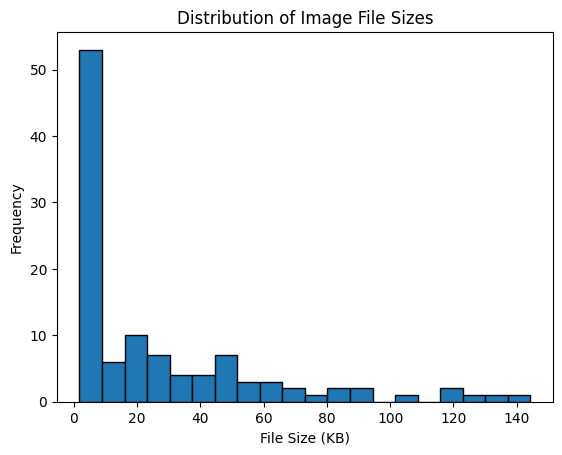

In [105]:
plot_histogram(image_sizes_kb, "Distribution of Image File Sizes", "File Size (KB)")

### Al procesar la data original se observa que a partir de 150 los pesos crecen mucho y son muy pocos casos, para mejorar esto se propone eliminar todos los archivos con peso mayor a el promedio + desviación estándar, la data utilizada actualmente es una versión reducida por lo que no se realizará aquí ninguna eliminación, dicha eliminación ya fué realizada

In [106]:
### Para la eliminación se usó este código

# print("Deleting oversized images")
# size_limit = stats['mean'] + stats['std_dev'] # Se define el límite de tamaño como la media más la desviación estándar
# image_sizes_kb = [size for size in image_sizes_kb if size < size_limit] # Se eliminan las imágenes que superan el límite
# stats = extract_statistics(image_sizes_kb) # Se recalculan las estadísticas
# print(f"Statistics: {stats}")

In [107]:
# ### Generando el histograma nuevamente

# plot_histogram(image_sizes_kb, "Distribution of Image File Sizes", "File Size (KB)")

### Con esta nueva distribución se puede determinar que imágenes pequeñas son páginas sin contenido, igualmente para el cálculo de este threshold se usará el promedio multiplicado por un factor para escoger el mejor resultado por prueba y error para dicho dataset

In [108]:
### Se define una función para extraer el umbral de imágenes en blanco
def find_blank_threshold(stats):
    """
    Calculates and returns a threshold value based on the mean and standard deviation of image sizes.

    This function computes a threshold value by subtracting the standard deviation from the mean of a set of image sizes.
    The resulting threshold can be used to identify images that are significantly smaller than the average, potentially
    indicating blank or content-less images.

    Args:
        stats (dict): A dictionary containing statistical measures of image sizes. Must include 'mean' and 'std_dev' keys.

    Returns:
        float: The calculated threshold value.

    """
    try:
        # Calculate the threshold by subtracting the standard deviation from the mean
        threshold = stats['mean']
        return threshold  # Return the calculated threshold
    except KeyError:
        print("Error: Input dictionary must contain 'mean' and 'std_dev' keys.")
        return None

In [109]:
### Se calcula y extrae el umbral para detectar páginas en blanco
threshold_kb = find_blank_threshold(stats)

print(f"Threshold for detecting blank pages: {threshold_kb:.2f} KB")

Threshold for detecting blank pages: 26.74 KB


In [110]:
### Con este umbral se pueden eliminar las imágenes que son consideradas en blanco

blank_pages = [size for size in image_sizes_kb if size < threshold_kb]
print(f"Number of aparent blank pages without threshold: {len(blank_pages)}")

Number of aparent blank pages without threshold: 72


In [111]:
### Ahora se definen las funciones para mover las imágenes pequeñas a un directorio específico,
### teniendo en cuenta el paralelizado

def move_image(image_file, destination_folder, size_threshold_bytes, per_threshold_size):
    """
    Moves an image file to a specified destination folder if its size is below a calculated threshold.

    This function checks if the size of an image file is less than a specified threshold (calculated as size_threshold_bytes
    multiplied by per_threshold_size) and moves the file to a given destination folder if the condition is met. It handles any
    exceptions that occur during the process, printing an error message with the file name.

    Args:
        image_file (Path): A Path object representing the image file to be moved.
        destination_folder (str): The path to the destination folder where the image should be moved.
        size_threshold_bytes (int): The base size threshold in bytes.
        per_threshold_size (float): A multiplier to adjust the base size threshold.

    """
    try:
        # Get the size of the image file
        image_size = image_file.stat().st_size
        # Check if the image size is below the calculated threshold
        if image_size < size_threshold_bytes * per_threshold_size:
            # Move the image file to the destination folder
            shutil.move(str(image_file), Path(destination_folder) / image_file.name)
            # Print a message indicating the successful move
            print(f"Moved {image_file.name} to {destination_folder}")
    except Exception as e:
        # Print an error message if an exception occurs
        print(f"Error moving {image_file.name}: {e}")

def move_small_images(source_folder, destination_folder, size_threshold_kb, max_workers, per_threshold_size):
    """
    Moves small PNG images from a source folder to a destination folder based on a size threshold.

    This function searches for PNG images in the specified source folder and moves those whose sizes are below a certain threshold
    to the destination folder. The size threshold is defined by the size_threshold_kb parameter, adjusted by per_threshold_size.
    The operation is parallelized using a ThreadPoolExecutor to improve performance, especially in directories with a large number
    of files.

    Args:
        source_folder (str): The path to the source folder containing PNG images to be moved.
        destination_folder (str): The path to the destination folder where qualifying images will be moved.
        size_threshold_kb (int): The size threshold in kilobytes. Images smaller than this (after adjustment) will be moved.
        max_workers (int): The maximum number of worker threads to use for parallel processing.
        per_threshold_size (float): A multiplier to adjust the size threshold.

    """
    try:
        # Convert the size threshold from kilobytes to bytes for comparison
        size_threshold_bytes = size_threshold_kb * 1024

        # Create the destination folder if it doesn't exist, including any necessary parent directories
        Path(destination_folder).mkdir(parents=True, exist_ok=True)

        # Recursively find all PNG files in the source folder
        image_files = list(Path(source_folder).rglob("*.png"))

        # Initialize a ThreadPoolExecutor with the specified number of worker threads
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Asynchronously submit tasks to move qualifying images
            futures = [executor.submit(move_image, image_file, destination_folder, size_threshold_bytes, per_threshold_size) for image_file in image_files]

            # Wait for all submitted tasks to complete and handle any exceptions that occur
            for future in as_completed(futures):
                future.result()

    except Exception as e:
        # Log any errors that occur during the process
        print(f"Error processing images: {e}")

In [112]:
### Ahora se define que el directorio a procesar es el directorio donde se invirtieron los colores
source_folder = dest_dir
### Se define el directorio de destino
destination_folder = "data_processed/Tobacco 800 Dataset blank_images"
### se define el umbral de tamaño en kilobytes, en este caso después de prueba y error se encontré que este valor es adecuado
per_threshold_size = 0.2 # este valor se encontró después de prueba y error y depende si se usa esta data reducida o laa completa

### Finalmente movemos las imágenes a un directorio de imágenes en blanco, teniendo en cuenta el umbral
move_small_images(source_folder, destination_folder, threshold_kb, max_workers, per_threshold_size)

Moved qit05f00-page2_1.png to data_processed/Tobacco 800 Dataset blank_images
Moved cgy54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved qit05f00-page2_23.png to data_processed/Tobacco 800 Dataset blank_images
Moved eey54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved hti31a00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved ivw54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved qit05f00-page2_21.png to data_processed/Tobacco 800 Dataset blank_images
Moved zqc25f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved cgx54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved ofy54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved dic45f00_4.png to data_processed/Tobacco 800 Dataset blank_images
Moved jnx54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved qit05f00-page2_15.png to data_processed/Tobacco 800 Dataset blank_images
Moved aww54f00_2.png to data_processe

### Durante las pruebas con este dataset se observó que el mejor valor para extraer imágenes por peso es usar el 35% del valor del promedio - desviación estándar para el dataset completo y 20% del promedio para el dataset reducido, cada dataset tendrá su propio valor y deberá ser ajustado a cada caso

### Una vez se extraen las imágenes por peso, se puede aplicar otra técnica que es extraer la varianza del laplaciano de la imagen, como en el caso del peso se tendrá un valor para cada imagen con una distribución, si los valores son muy dispersos se debería realizar un filtro

In [113]:
### Definir función para calcular laplaciano

def calculate_laplacian(image_path):
    """
    Calculates the Laplacian variance of an image, which can be used as a measure of sharpness or focus.

    This function reads an image from a specified path, converts it to grayscale, and then calculates the Laplacian variance.
    The Laplacian variance is a measure of the sharpness of an image; higher values indicate a sharper image. If the image
    cannot be found, read, or processed for any reason, the function handles the exception by printing an error message and
    returning infinity as the variance, indicating an error condition.

    Args:
        image_path (str): The file path of the image for which to calculate the Laplacian variance.

    Returns:
        tuple: A tuple containing the image path and its Laplacian variance. If an error occurs, the variance is set to infinity.

    """
    try:
        # Check if the image file exists at the specified path
        if not os.path.isfile(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")

        # Read the image from the path in grayscale mode
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # If the image is not successfully read, raise an error
        if image is None:
            raise ValueError(f"Unable to read the image: {image_path}")

        # Calculate the Laplacian variance of the image
        laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

        # Return the image path and its Laplacian variance
        return image_path, laplacian_var.item()

    except Exception as e:
        # If an error occurs, print the error message and return infinity as the variance
        print(f"Error calculating Laplacian variance for {image_path}: {e}")
        return image_path, float('inf')

def process_images_laplacian(source_folder, max_workers):
    """
    Processes a set of PNG images in a source folder to calculate their Laplacian variance in parallel.

    This function scans a specified folder for PNG images, then calculates the Laplacian variance for each image using
    a ThreadPoolExecutor to parallelize the work. The Laplacian variance is a measure of the sharpness of an image.
    The results are returned as a list of tuples, each containing the image path and its corresponding Laplacian variance.
    If an error occurs during the processing of an image, an error message is printed, and the processing continues with
    the next image. The function handles and prints any exceptions that occur during the overall process.

    Args:
        source_folder (str): The path to the folder containing the PNG images to be processed.
        max_workers (int): The maximum number of worker threads to use for processing the images in parallel.

    Returns:
        list: A list of tuples, each containing the image path and its Laplacian variance. If an error occurs during the
              processing of an image, that image is skipped, and processing continues with the next image.

    """
    try:
        # Initialize an empty list to hold the results
        images = []
        # List all PNG files in the source folder
        image_paths = [os.path.join(source_folder, filename) for filename in os.listdir(source_folder) if filename.endswith(".png")]

        # Use ThreadPoolExecutor to parallelize the calculation of Laplacian variance
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit tasks to calculate Laplacian variance for each image
            futures = {executor.submit(calculate_laplacian, image_path): image_path for image_path in image_paths}

            # Process the results as they become available
            for future in as_completed(futures):
                image_path = futures[future]
                try:
                    # Attempt to get the result of the future
                    image_path, laplacian_value = future.result()
                    # Append the result to the images list
                    images.append((image_path, laplacian_value))
                except Exception as e:
                    # Print an error message if an exception occurs
                    print(f"Error processing image {image_path}: {e}")

        # Return the list of image paths and their Laplacian variances
        return images

    except Exception as e:
        # Print an error message if an exception occurs during the overall process
        print(f"Error processing images: {e}")

In [114]:
### se extraen los valores de laplaciano de las imágenes
images = process_images_laplacian(source_folder, max_workers)
images_laplacian_values = [img[1] for img in images]

### Se extraen las estadísticas de los valores de laplaciano usando la función anteriormente definida
stats_laplacian = extract_statistics(images_laplacian_values)
print(f"Statistics: {stats_laplacian}")

Statistics: {'max': 39911.24404732768, 'min': 365.6960123981966, 'mean': 5953.785011041755, 'std_dev': 6352.991162185977}


### Aquí se vuelve a observar una desviación elevada, por lo que se realiza un filtro, para este dataset reducido no se aplicarán filtros

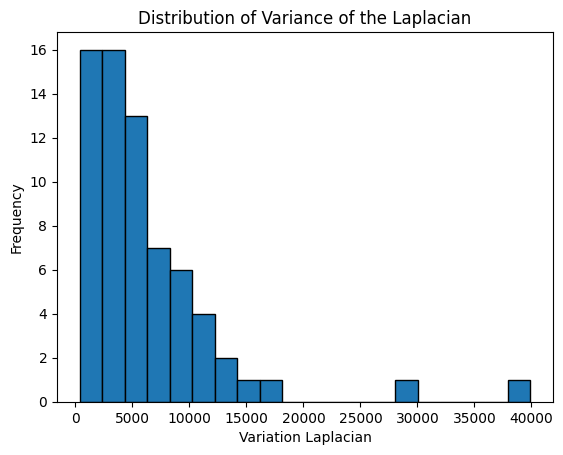

In [115]:
### Para observar mejor el comportamiento se muestra un histograma

plot_histogram(images_laplacian_values, "Distribution of Variance of the Laplacian", "Variation Laplacian")

### Para la eliminación de datos con el laplaciano se usó el mismo aacercamiento que en el caso de los pesos, aqui no se eliminan por usar el dataset reducido

In [116]:
### Calculamos el umbral para detectar páginas en blanco
threshold_laplacian = find_blank_threshold(stats_laplacian)
print(f"Threshold for detecting blank pages: {threshold_laplacian:.2f}")

Threshold for detecting blank pages: 5953.79


In [117]:
### Se define la función para mover las imágenes con valores de laplaciano bajos a un directorio específico

def move_image_threshold(path, value, destination_folder, threshold):
    """
    Moves an image file to a specified destination folder if its associated value is below a given threshold.

    This function checks if a given value (e.g., a measure of image quality or size) is below a specified threshold. If so,
    it moves the image file from its current location to a specified destination folder. The function prints a message
    indicating the successful move of the file.

    Args:
        path (str): The file path of the image to be moved.
        value (float): The value associated with the image, used to determine if the image should be moved.
        destination_folder (str): The path to the destination folder where the image should be moved if the condition is met.
        threshold (float): The threshold value. If the image's associated value is below this, it will be moved.

    """
    if value < threshold:
        # Extract the filename from the given path
        filename = os.path.basename(path)
        # Construct the full destination path by combining the destination folder and the filename
        destination = os.path.join(destination_folder, filename)
        # Move the file from its current location to the destination
        shutil.move(path, destination)
        # Print a message indicating the file has been moved
        print(f"Moved {path} to {destination}")

def move_images_by_laplacian(images, destination_folder, threshold, per_threshold_laplaciano, max_workers):
    """
    Moves images to a specified destination folder based on their Laplacian variance compared to a threshold.

    This function adjusts a base threshold by a specified multiplier (per_threshold_laplaciano) to determine a final threshold.
    It then iterates over a list of images (each represented by a tuple containing the image path and its Laplacian variance)
    and moves those with a Laplacian variance below the adjusted threshold to a specified destination folder. The moving
    operation is performed in parallel using a ThreadPoolExecutor to improve efficiency.

    Args:
        images (list of tuples): A list where each tuple contains the path to an image and its Laplacian variance value.
        destination_folder (str): The path to the folder where images meeting the criteria should be moved.
        threshold (float): The base threshold value for Laplacian variance. Images with a variance below this (after adjustment)
                           will be moved.
        per_threshold_laplaciano (float): The multiplier used to adjust the base threshold value.

    """
    # Adjust the threshold by the specified multiplier
    threshold = per_threshold_laplaciano * threshold
    print(f"Using threshold: {threshold:.2f}")
    
    # Use ThreadPoolExecutor to parallelize the moving operation
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        # Submit a task for each image to move it if it meets the criteria
        for path, value in images:
            futures.append(executor.submit(move_image_threshold, path, value, destination_folder, threshold))
        
        # Wait for all futures to complete and handle exceptions
        for future in as_completed(futures):
            try:
                # Attempt to get the result of the future, which will raise an exception if the task failed
                future.result()
            except Exception as e:
                # Print an error message if moving an image failed
                print(f"Error moving image: {e}")

In [118]:
### Se define el umbral de laplaciano para detectar páginas en blanco
per_threshold_laplaciano = 0.15

In [119]:
move_images_by_laplacian(images, destination_folder, threshold_laplacian, per_threshold_laplaciano, max_workers)

Using threshold: 893.07
Moved data_processed/Tobacco 800 Dataset whitened/btt85f00-page2_1.png to data_processed/Tobacco 800 Dataset blank_images/btt85f00-page2_1.png
Moved data_processed/Tobacco 800 Dataset whitened/crr09c00_2.png to data_processed/Tobacco 800 Dataset blank_images/crr09c00_2.png
Moved data_processed/Tobacco 800 Dataset whitened/pek94c00_3.png to data_processed/Tobacco 800 Dataset blank_images/pek94c00_3.png
Moved data_processed/Tobacco 800 Dataset whitened/vrr09c00-page03_1.png to data_processed/Tobacco 800 Dataset blank_images/vrr09c00-page03_1.png
Moved data_processed/Tobacco 800 Dataset whitened/duz52d00-page02-var_1.png to data_processed/Tobacco 800 Dataset blank_images/duz52d00-page02-var_1.png
Moved data_processed/Tobacco 800 Dataset whitened/erk44a00_2.png to data_processed/Tobacco 800 Dataset blank_images/erk44a00_2.png
Moved data_processed/Tobacco 800 Dataset whitened/qin54c00_2.png to data_processed/Tobacco 800 Dataset blank_images/qin54c00_2.png
Moved data_

In [120]:
### Cantidad de imágenes en blanco
print(len(os.listdir(destination_folder)))

55


### Para el dataset Tobacco 800 Dataset se encontraron 55 imágenes sin contenido, por lo tanto se seleccionarán 55 imágenes al azar con contenido para tener una base 50/50, estas imágenes serán posteriormente agregadas al Dataset suministrado

In [121]:
# Define the folder paths
blank_images_folder = 'data_processed/Tobacco 800 Dataset blank_images'
source_from_blank = 'data_processed/Tobacco 800 Dataset whitened'
new_folder = 'nuevos_con_contenido'

# Ensure the new folder exists
os.makedirs(new_folder, exist_ok=True)

# Step 1: Count the number of PNG files in the blank_images folder
blank_images_count = len([f for f in os.listdir(blank_images_folder) if f.endswith('.png')])
print(f'Number of PNG files in blank_images folder: {blank_images_count}')

# Step 2: Get the list of files in the whitened folder
whitened_files = os.listdir(source_from_blank)

# Ensure there are enough files to select
if blank_images_count > len(whitened_files):
    raise ValueError("Not enough files in the whitened folder to select from")

# Select random files from the whitened folder
selected_files = random.sample(whitened_files, blank_images_count)

# Step 3: Move the selected files to the new folder
for file in selected_files:
    src_path = os.path.join(source_from_blank, file)
    dest_path = os.path.join(new_folder, file)
    shutil.move(src_path, dest_path)

print(f'Successfully moved {blank_images_count} files to {new_folder}')


Number of PNG files in blank_images folder: 55
Successfully moved 55 files to nuevos_con_contenido


### 2.2 Extracción de imágenes sin contenido para Tobacco3482 Dataset <a id="second1-2"></a>

### Este dataset tiene las imágenes en formato jpg, se convertirán a png para que todas las imágenes sean png

In [122]:
### se definen las funciones para convertir las imágenes de jpg a png
### Mantienendo el paralelizado

def convert_file(jpg_path, output_folder):
    """
    Converts a JPG image to PNG format and saves it to a specified output folder.

    This function opens a JPG image from a given path, converts it to PNG format, and saves the converted image
    to a specified output folder. The name of the converted PNG file is the same as the original JPG file, but with
    the PNG extension. If the conversion process encounters an error, an error message is printed.

    Args:
        jpg_path (str): The file path of the JPG image to be converted.
        output_folder (str): The path to the folder where the converted PNG image should be saved.

    """
    try:
        # Open the JPG image from the given path
        jpg_image = Image.open(jpg_path)
        # Construct the path for the converted PNG image
        png_path = os.path.join(output_folder, os.path.splitext(os.path.basename(jpg_path))[0] + ".png")
        # Save the image in PNG format to the constructed path
        jpg_image.save(png_path, "PNG")
        # Print a message indicating successful conversion
        print(f"Converted {jpg_path} to {png_path}")
    except Exception as e:
        # Print an error message if the conversion fails
        print(f"Error converting {jpg_path}: {e}")

def convert_jpg_to_png(input_folder, output_folder, max_workers):
    """
    Converts all JPG images in a given input folder (and its subdirectories) to PNG format,
    saving them in a specified output folder.

    This function recursively searches through the input folder for JPG images, converts each
    found image to PNG format using a separate function `convert_file`, and saves the converted
    images to the specified output folder. The conversion process is parallelized using a
    ThreadPoolExecutor to improve efficiency. If the output folder does not exist, it is created.
    Any exceptions that occur during the conversion process are caught and printed.

    Args:
        input_folder (str): The path to the folder containing the JPG images to be converted.
                            This function will also search through all subdirectories of this folder.
        output_folder (str): The path to the folder where the converted PNG images should be saved.
                             This folder will be created if it does not already exist.

    """
    try:
        # Ensure the output folder exists, create it if it doesn't
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Initialize a list to keep track of futures for asynchronous execution
        futures = []

        # Use ThreadPoolExecutor to manage concurrent execution of image conversion tasks
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Recursively walk through the input folder and its subdirectories
            for root, _, files in os.walk(input_folder):
                # For each file in the directories
                for file in files:
                    # Check if the file is a JPG image
                    if file.endswith(".jpg"):
                        # Construct the full path to the JPG file
                        jpg_path = os.path.join(root, file)
                        # Submit a task to convert the JPG file to PNG format
                        futures.append(executor.submit(convert_file, jpg_path, output_folder))

        # Wait for all submitted conversion tasks to complete
        for future in as_completed(futures):
            try:
                # Attempt to get the result of the future, raising any exceptions that occurred during execution
                future.result()
            except Exception as e:
                # Print any exceptions that occurred during the conversion process
                print(f"Exception occurred: {e}")
    except Exception as e:
        # Print any exceptions that occurred during the overall process
        print(f"Error converting JPG to PNG: {e}")

In [123]:
input_folder = "data_original/Tobacco3482 Dataset"
output_folder = "data_processed/Tobacco3482 Dataset PNG"
convert_jpg_to_png(input_folder, output_folder, max_workers)

Converted data_original/Tobacco3482 Dataset/example_reduced_1/0000642640.jpg to data_processed/Tobacco3482 Dataset PNG/0000642640.png
Converted data_original/Tobacco3482 Dataset/example_reduced_1/0000002770.jpg to data_processed/Tobacco3482 Dataset PNG/0000002770.png
Converted data_original/Tobacco3482 Dataset/example_reduced_2/2070383449b_3450.jpg to data_processed/Tobacco3482 Dataset PNG/2070383449b_3450.png
Converted data_original/Tobacco3482 Dataset/example_reduced_1/528744679+-4679.jpg to data_processed/Tobacco3482 Dataset PNG/528744679+-4679.png
Converted data_original/Tobacco3482 Dataset/example_reduced_2/2072389709c.jpg to data_processed/Tobacco3482 Dataset PNG/2072389709c.png
Converted data_original/Tobacco3482 Dataset/example_reduced_1/516695861+-5861.jpg to data_processed/Tobacco3482 Dataset PNG/516695861+-5861.png
Converted data_original/Tobacco3482 Dataset/example_reduced_1/70118949-8950.jpg to data_processed/Tobacco3482 Dataset PNG/70118949-8950.png
Converted data_origina

In [124]:
### Con las funciones anteriores podemos convertir todas las imágenes de un directorio a fondo blanco

### Seleccionamos el directorio de origen y destino

source_dir = 'data_processed/Tobacco3482 Dataset PNG' # Directorio de origen
dest_dir = 'No_Path' # En este caso No_Path es el flag para no guardar imágenes invertidas
max_workers = None # Número de workers para paralelizar el proceso, si es None se usan todos los disponibles
invert_colors = False # Invertir los colores de las imágenes, debido a que se procesaran varias imágenes, no todas necesitan inversioón de colores

image_sizes = invert_colors_process_images(source_dir, dest_dir, max_workers, invert_colors) #invierte colores y extrae pesos de cada una

image_sizes_kb = [size / 1024 for size in image_sizes] # Convertir los tamaños de bytes a kilobytes

### Para el filtro y organización de la data se usará el mismo acercamiento que con el dataset anterior

In [125]:
### Se extraen las estadísticas
stats = extract_statistics(image_sizes_kb)

print(f"Statistics: {stats}")
### Se observa que la desviación estandar es muy elevada, esta distribución de datos no nos sirve

Statistics: {'max': 1693.205078125, 'min': 19.3955078125, 'mean': 295.30397066156917, 'std_dev': 348.8746111692627}


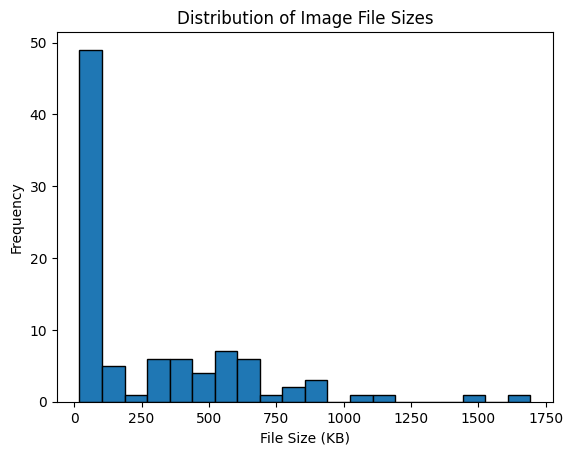

In [126]:
### Para observar mejor el comportamiento se muestra un histograma

plot_histogram(image_sizes_kb, "Distribution of Image File Sizes", "File Size (KB)")


### Al procesar la data original se observa que a partir de 1500 los pesos crecen mucho y son muy pocos casos, para mejorar esto se propone eliminar todos los archivos con peso mayor a el promedio + desviación estándar, la data utilizada actualmente es una versión reducida por lo que no se realizará aquí ninguna eliminación, dicha eliminación ya fué realizada

### Como ejemplo demostrativo se adjutan unos pantallazos de la data que se estaba obteniendo para este caso.

### Esta imagen muestra la distribución de la data original
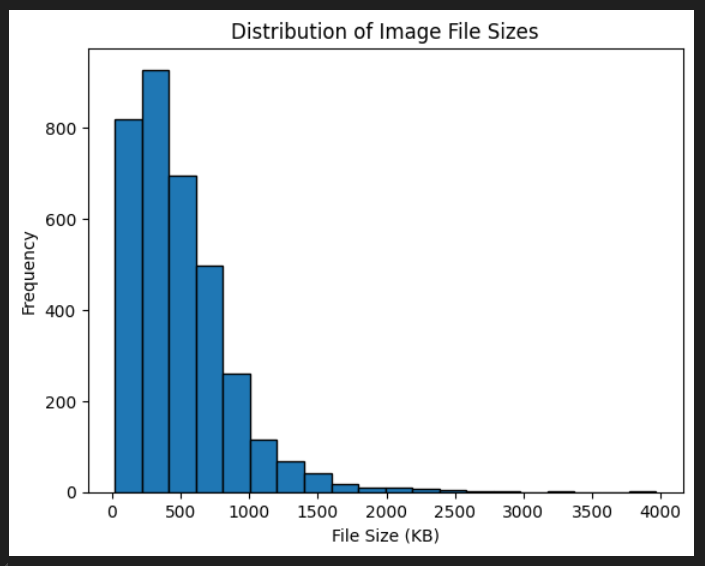

### Esta imagen muestra la distribución de la data limpiada

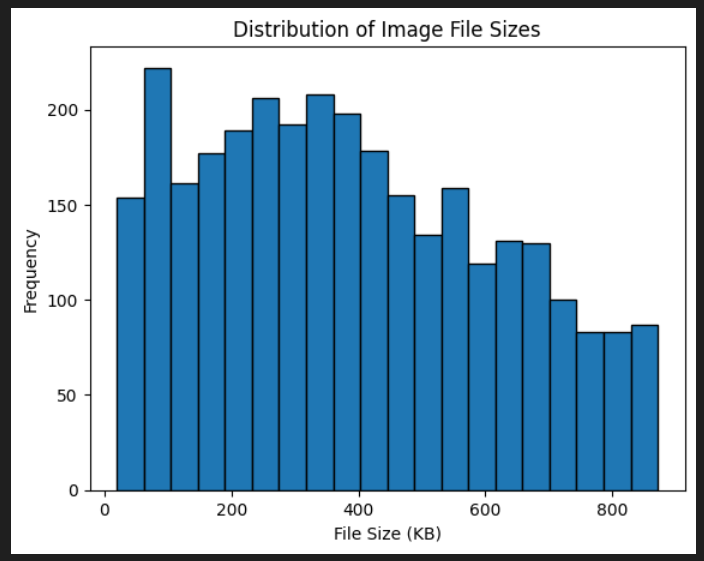

In [127]:
# ## Para la eliminación se usó este código

# print("Deleting oversized images")
# size_limit = stats['mean'] + stats['std_dev'] # Se define el límite de tamaño como la media más la desviación estándar
# image_sizes_kb = [size for size in image_sizes_kb if size < size_limit] # Se eliminan las imágenes que superan el límite
# stats = extract_statistics(image_sizes_kb) # Se recalculan las estadísticas
# print(f"Statistics: {stats}")

In [128]:
# ### Generando el histograma nuevamente

# plot_histogram(image_sizes_kb, "Distribution of Image File Sizes", "File Size (KB)")

In [129]:
### Se calcula y extrae el umbral para detectar páginas en blanco
threshold_kb = find_blank_threshold(stats)

print(f"Threshold for detecting blank pages: {threshold_kb:.2f} KB")

Threshold for detecting blank pages: 295.30 KB


In [130]:
### Con este umbral se pueden eliminar las imágenes que son consideradas en blanco

blank_pages = [size for size in image_sizes_kb if size < threshold_kb]
print(f"Number of aparent blank pages without threshold: {len(blank_pages)}")

Number of aparent blank pages without threshold: 57


In [131]:
source_folder = source_dir
### Se define el directorio de destino
destination_folder = "data_processed/Tobacco3482 Dataset blank_images"
### se define el umbral de tamaño en kilobytes, en este caso después de prueba y error se encontré que este valor es adecuado
per_threshold_size = 0.15 # este valor se encontró después de prueba y error y depende si se usa esta data reducida o la completa

### Finalmente movemos las imágenes a un directorio de imágenes en blanco, teniendo en cuenta el umbral
move_small_images(source_folder, destination_folder, threshold_kb, max_workers, per_threshold_size)

Moved 2085272616a.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2075574247c_4248.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2082693424a.png to data_processed/Tobacco3482 Dataset blank_images
Moved 0000642640.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085791853c_1854.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085752507d.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085782997a.png to data_processed/Tobacco3482 Dataset blank_images
Moved 0000002770.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2071191029.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085696947f_6948.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2073414412.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2078337799.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085770392c_0393.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085126533a.png to data_proces

### Durante las pruebas con este dataset se observó que el mejor valor para extraer imágenes por peso es usar el 35% del valor del promedio - desviación estándar ara el dataset completo y 20% del promedio para el dataset reducido, cada dataset tendrá su propio valor y deberá ser ajustado a cada caso

### Ahora se aplica el laplaciano

In [132]:
### se extraen los valores de laplaciano de las imágenes
images = process_images_laplacian(source_folder, max_workers)
images_laplacian_values = [img[1] for img in images]

### Se extraen las estadísticas de los valores de laplaciano usando la función anteriormente definida
stats_laplacian = extract_statistics(images_laplacian_values)
print(f"Statistics: {stats_laplacian}")

Statistics: {'max': 21880.235586352428, 'min': 167.9344212198993, 'mean': 4566.937704046446, 'std_dev': 4385.449623852938}


### Se realiza el mismo desarrollo que en casos anteriores

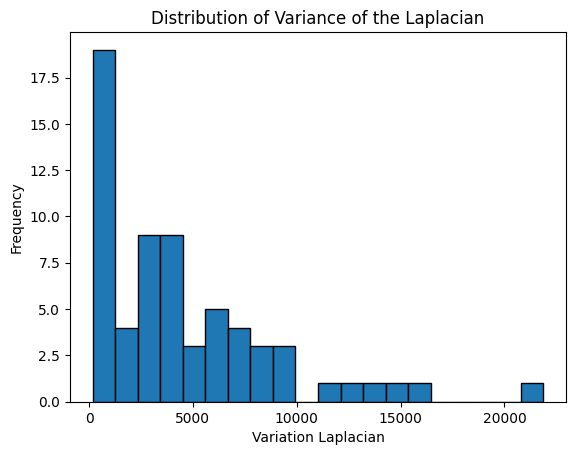

In [133]:
### Para observar mejor el comportamiento se muestra un histograma

plot_histogram(images_laplacian_values, "Distribution of Variance of the Laplacian", "Variation Laplacian")

### Como ejemplo esta es la imagen de la distribución del laplaciano antes

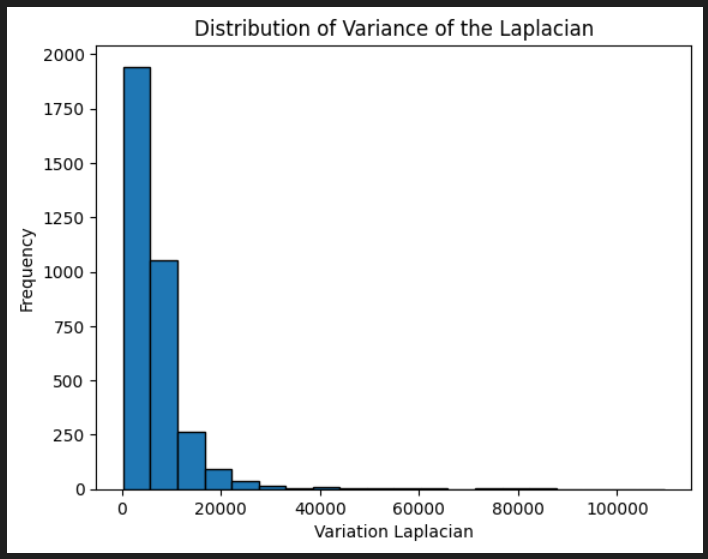

### Esta es la imagen después

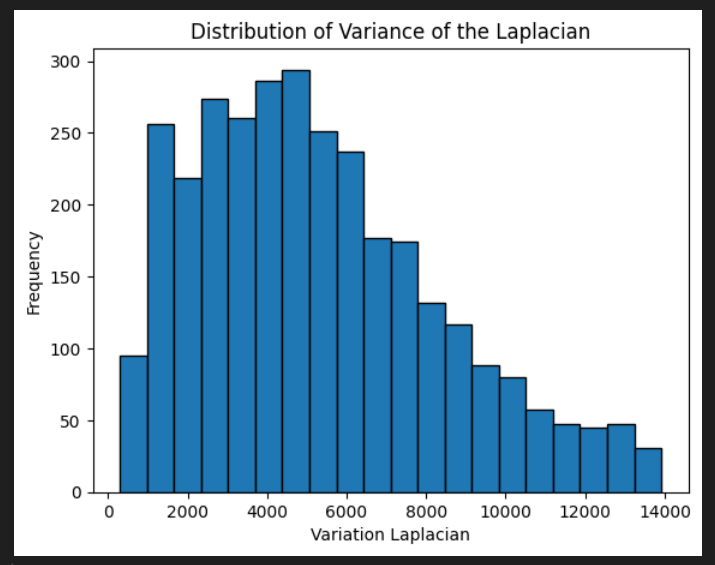

In [134]:
# ## Para la eliminación se usó este código
# print("Deleting oversized images")
# size_limit = stats_laplacian['mean'] + stats_laplacian['std_dev'] # Se define el límite de tamaño como la media más la desviación estándar
# images_laplacian_values = [size for size in images_laplacian_values if size < size_limit] # Se eliminan las imágenes que superan el límite
# stats_laplacian = extract_statistics(images_laplacian_values)
# print(f"Statistics: {stats_laplacian}")

In [135]:
# plot_histogram(images_laplacian_values, "Distribution of Variance of the Laplacian", "Variation Laplacian")

In [136]:
### Calculamos el umbral para detectar páginas en blanco
threshold_laplacian = find_blank_threshold(stats_laplacian)
print(f"Threshold for detecting blank pages: {threshold_laplacian:.2f}")

Threshold for detecting blank pages: 4566.94


In [137]:
### Se define el umbral de laplaciano para detectar páginas en blanco
per_threshold_laplaciano = 0.18

In [138]:
move_images_by_laplacian(images, destination_folder, threshold_laplacian, per_threshold_laplaciano, max_workers)

Using threshold: 822.05
Moved data_processed/Tobacco3482 Dataset PNG/2085788705.png to data_processed/Tobacco3482 Dataset blank_images/2085788705.png
Moved data_processed/Tobacco3482 Dataset PNG/2083647284d_7285.png to data_processed/Tobacco3482 Dataset blank_images/2083647284d_7285.png
Moved data_processed/Tobacco3482 Dataset PNG/2084289636b.png to data_processed/Tobacco3482 Dataset blank_images/2084289636b.png
Moved data_processed/Tobacco3482 Dataset PNG/2060540658.png to data_processed/Tobacco3482 Dataset blank_images/2060540658.png
Moved data_processed/Tobacco3482 Dataset PNG/2063603124.png to data_processed/Tobacco3482 Dataset blank_images/2063603124.png
Moved data_processed/Tobacco3482 Dataset PNG/2501268920-a.png to data_processed/Tobacco3482 Dataset blank_images/2501268920-a.png
Moved data_processed/Tobacco3482 Dataset PNG/2085768458a.png to data_processed/Tobacco3482 Dataset blank_images/2085768458a.png
Moved data_processed/Tobacco3482 Dataset PNG/2080891364d_1365.png to data_

In [139]:
### Cantidad de imágenes en blanco
print(len(os.listdir(destination_folder)))

47


### Para el dataset Tobacco3482 Dataset se encontraron 47 imágenes sin contenido, por lo tanto se seleccionarán 47 imágenes al azar con contenido para tener una base 50/50, estas imágenes serán posteriormente agregadas al Dataset suministrado

In [140]:
# Define the folder paths
blank_images_folder = 'data_processed/Tobacco3482 Dataset blank_images'
source_from_blank = 'data_processed/Tobacco3482 Dataset PNG'
new_folder = 'nuevos_con_contenido_2'

# Ensure the new folder exists
os.makedirs(new_folder, exist_ok=True)

# Step 1: Count the number of PNG files in the blank_images folder
blank_images_count = len([f for f in os.listdir(blank_images_folder) if f.endswith('.png')])
print(f'Number of PNG files in blank_images folder: {blank_images_count}')

# Step 2: Get the list of files in the whitened folder
whitened_files = os.listdir(source_from_blank)

# Ensure there are enough files to select
if blank_images_count > len(whitened_files):
    raise ValueError("Not enough files in the whitened folder to select from")

# Select random files from the whitened folder
selected_files = random.sample(whitened_files, blank_images_count)

# Step 3: Move the selected files to the new folder
for file in selected_files:
    src_path = os.path.join(source_from_blank, file)
    dest_path = os.path.join(new_folder, file)
    shutil.move(src_path, dest_path)

print(f'Successfully moved {blank_images_count} files to {new_folder}')


Number of PNG files in blank_images folder: 47
Successfully moved 47 files to nuevos_con_contenido_2


### 2.3 Extracción de imágenes sin contenido para RVL-CDIP Dataset <a id="second1-3"></a>

### Este dataset tiene las imágenes en formato tif, se convertirán a png para normalizar

In [141]:
# Function to convert TIFF to PNG
def convert_tiff_to_png(tiff_path, output_folder):
    """
    Converts a TIFF image to PNG format and saves it to a specified output folder.

    This function opens a TIFF image from a given path, converts it to PNG format, and saves the converted image
    to a specified output folder. The name of the converted PNG file is the same as the original TIFF file, but with
    the PNG extension. If the conversion process encounters an error, an error message is printed.

    Args:
        tiff_path (str): The file path of the TIFF image to be converted.
        output_folder (str): The path to the folder where the converted PNG image should be saved.

    """
    try:
        # Open the TIFF image from the given path
        tiff_image = Image.open(tiff_path)
        # Construct the path for the converted PNG image
        png_path = os.path.join(output_folder, os.path.splitext(os.path.basename(tiff_path))[0] + ".png")
        # Save the image in PNG format to the constructed path
        tiff_image.save(png_path, "PNG")
        # Print a message indicating successful conversion
        print(f"Converted {tiff_path} to {png_path}")
    except Exception as e:
        # Print an error message if the conversion fails
        print(f"Error converting {tiff_path}: {e}")

# Function to process each file
def process_file(file_path, output_folder):
    """
    Processes a given file by converting it from TIFF to PNG format if applicable, and saves the converted file to a specified output folder.

    This function checks if the provided file path corresponds to a TIFF image (either .tif or .tiff extension). If so, it calls
    another function `convert_tiff_to_png` to perform the conversion and save the converted image to the given output folder.
    This is designed to be a part of a larger workflow where multiple files of various types might be processed differently
    based on their file type.

    Args:
        file_path (str): The path to the file to be processed.
        output_folder (str): The path to the folder where the processed file should be saved, if applicable.

    """
    # Check if the file is a TIFF image
    if file_path.lower().endswith(".tif") or file_path.lower().endswith(".tiff"):
        # Convert the TIFF image to PNG format and save it to the output folder
        convert_tiff_to_png(file_path, output_folder)

# Parallel execution using ThreadPoolExecutor
def parallel_convert_tiff_to_png(input_folder, output_folder, max_workers):
    """
    Converts all TIFF images found in a given input folder (and its subdirectories) to PNG format in parallel,
    saving them in a specified output folder.

    This function first ensures that the output folder exists, creating it if necessary. It then recursively
    lists all files in the input folder and its subdirectories. Each TIFF file found is processed in parallel
    using a ThreadPoolExecutor to convert it to PNG format. The conversion process leverages the `process_file`
    function to determine if a file is a TIFF image and, if so, to perform the conversion. This approach
    significantly speeds up the processing of large numbers of files by utilizing concurrent execution.

    Args:
        input_folder (str): The path to the folder containing the TIFF images to be converted. This function
                            will search through all subdirectories of this folder as well.
        output_folder (str): The path to the folder where the converted PNG images should be saved. This folder
                             will be created if it does not already exist.

    """
    # Ensure the output folder exists, create it if it doesn't
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize a list to hold all file paths in the input folder and its subdirectories
    all_files = []
    for root, _, files in os.walk(input_folder):
        for file in files:
            # Construct the full path for each file
            file_path = os.path.join(root, file)
            # Add the file path to the list
            all_files.append(file_path)

    # Use ThreadPoolExecutor to manage concurrent execution of file processing tasks
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Initialize a list to keep track of futures for asynchronous execution
        futures = []
        for file_path in all_files:
            # Submit a task for processing each file, converting TIFF to PNG where applicable
            futures.append(executor.submit(process_file, file_path, output_folder))
        
        # Wait for all submitted tasks to complete, ensuring all files are processed
        for future in as_completed(futures):
            # Attempt to get the result of the future, which will raise any exceptions that occurred during execution
            future.result()


In [142]:
input_folder = "data_original/RVL-CDIP Dataset"
output_folder = "data_processed/RVL-CDIP Dataset PNG"
parallel_convert_tiff_to_png(input_folder, output_folder, max_workers)

Converted data_original/RVL-CDIP Dataset/example_reduced_1/0060335907.tif to data_processed/RVL-CDIP Dataset PNG/0060335907.pngConverted data_original/RVL-CDIP Dataset/example_reduced_1/83786254_6260.tif to data_processed/RVL-CDIP Dataset PNG/83786254_6260.png

Converted data_original/RVL-CDIP Dataset/example_reduced_1/50445637-5638.tif to data_processed/RVL-CDIP Dataset PNG/50445637-5638.png
Converted data_original/RVL-CDIP Dataset/example_reduced_1/96264241_4248.tif to data_processed/RVL-CDIP Dataset PNG/96264241_4248.png
Converted data_original/RVL-CDIP Dataset/example_reduced_1/50420594-0596.tif to data_processed/RVL-CDIP Dataset PNG/50420594-0596.png
Converted data_original/RVL-CDIP Dataset/example_reduced_1/0011837084.tif to data_processed/RVL-CDIP Dataset PNG/0011837084.png
Converted data_original/RVL-CDIP Dataset/example_reduced_1/50064816.tif to data_processed/RVL-CDIP Dataset PNG/50064816.png
Converted data_original/RVL-CDIP Dataset/example_reduced_1/91271755.tif to data_proc

In [143]:
### Con las funciones anteriores podemos convertir todas las imágenes de un directorio a fondo blanco

### Seleccionamos el directorio de origen y destino

source_dir = 'data_processed/RVL-CDIP Dataset PNG' # Directorio de origen
dest_dir = 'No_Path' # En este caso No_Path es el flag para no guardar imágenes invertidas
max_workers = None # Número de workers para paralelizar el proceso, si es None se usan todos los disponibles
invert_colors = False # Invertir los colores de las imágenes, debido a que se procesaran varias imágenes, no todas necesitan inversioón de colores

image_sizes = invert_colors_process_images(source_dir, dest_dir, max_workers, invert_colors) #invierte colores y extrae pesos de cada una

image_sizes_kb = [size / 1024 for size in image_sizes] # Convertir los tamaños de bytes a kilobytes

In [144]:
### Se extraen las estadísticas
stats = extract_statistics(image_sizes_kb)

print(f"Statistics: {stats}")
### Se observa que la desviación estandar es muy elevada, esta distribución de datos no nos sirve

Statistics: {'max': 416.3525390625, 'min': 3.958984375, 'mean': 54.06711647727273, 'std_dev': 66.4851191551569}


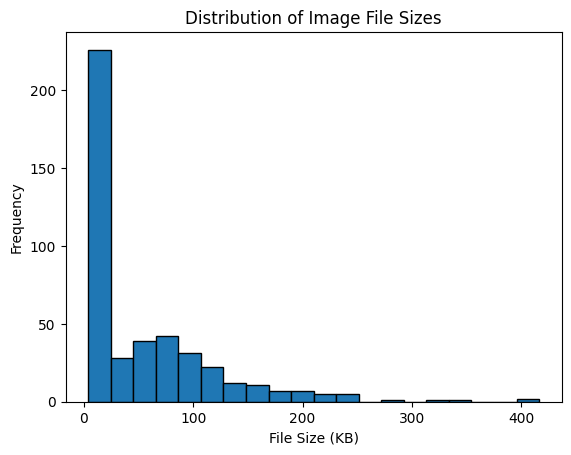

In [145]:
### Para observar mejor el comportamiento se muestra un histograma

plot_histogram(image_sizes_kb, "Distribution of Image File Sizes", "File Size (KB)")


In [146]:
# ## Para la eliminación se usó este código

# print("Deleting oversized images")
# size_limit = stats['mean'] + stats['std_dev'] # Se define el límite de tamaño como la media más la desviación estándar
# image_sizes_kb = [size for size in image_sizes_kb if size < size_limit] # Se eliminan las imágenes que superan el límite
# stats = extract_statistics(image_sizes_kb) # Se recalculan las estadísticas
# print(f"Statistics: {stats}")

In [147]:
# ### Generando el histograma nuevamente

# plot_histogram(image_sizes_kb, "Distribution of Image File Sizes", "File Size (KB)")

In [148]:
### Se calcula y extrae el umbral para detectar páginas en blanco
threshold_kb = find_blank_threshold(stats)

print(f"Threshold for detecting blank pages: {threshold_kb:.2f} KB")

Threshold for detecting blank pages: 54.07 KB


In [149]:
### Con este umbral se pueden eliminar las imágenes que son consideradas en blanco

blank_pages = [size for size in image_sizes_kb if size < threshold_kb]
print(f"Number of aparent blank pages without threshold: {len(blank_pages)}")

Number of aparent blank pages without threshold: 270


In [150]:
source_folder = source_dir
### Se define el directorio de destino
destination_folder = "data_processed/RVL-CDIP Dataset blank images"
### se define el umbral de tamaño en kilobytes, en este caso después de prueba y error se encontré que este valor es adecuado
per_threshold_size = 0.13 # este valor se encontró después de prueba y error y depende si se usa esta data reducida o laa completa

### Finalmente movemos las imágenes a un directorio de imágenes en blanco, teniendo en cuenta el umbral
move_small_images(source_folder, destination_folder, threshold_kb, max_workers, per_threshold_size)

Moved 2072707981.png to data_processed/RVL-CDIP Dataset blank images
Moved 50445637-5638.png to data_processed/RVL-CDIP Dataset blank images
Moved 2046027063.png to data_processed/RVL-CDIP Dataset blank images
Moved 2047155443.png to data_processed/RVL-CDIP Dataset blank images
Moved 2070260723.png to data_processed/RVL-CDIP Dataset blank images
Moved 10080465.png to data_processed/RVL-CDIP Dataset blank images
Moved 50583223-3230.png to data_processed/RVL-CDIP Dataset blank images
Moved 2070747650_7651.png to data_processed/RVL-CDIP Dataset blank images
Moved 2074074801_4806.png to data_processed/RVL-CDIP Dataset blank images
Moved 2070741209_1211.png to data_processed/RVL-CDIP Dataset blank images
Moved 2040583947.png to data_processed/RVL-CDIP Dataset blank images
Moved 2084391012d_1013.png to data_processed/RVL-CDIP Dataset blank images
Moved 2044065845.png to data_processed/RVL-CDIP Dataset blank images
Moved 50420594-0596.png to data_processed/RVL-CDIP Dataset blank images
Moved 

### Aplicando el laplaciano

In [151]:
### se extraen los valores de laplaciano de las imágenes
images = process_images_laplacian(source_folder, max_workers)
images_laplacian_values = [img[1] for img in images]

### Se extraen las estadísticas de los valores de laplaciano usando la función anteriormente definida
stats_laplacian = extract_statistics(images_laplacian_values)
print(f"Statistics: {stats_laplacian}")

Statistics: {'max': 24152.475693914435, 'min': 99.40523646120167, 'mean': 4998.78409756418, 'std_dev': 4570.0526301470045}


### Aquí se vuelve a observar una desviación elevada, por lo que se realiza un filtro, para este dataset reducido no se aplicarán filtros

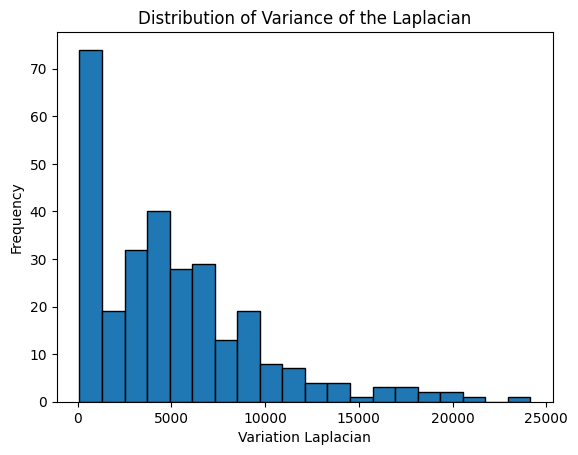

In [152]:
### Para observar mejor el comportamiento se muestra un histograma

plot_histogram(images_laplacian_values, "Distribution of Variance of the Laplacian", "Variation Laplacian")

In [153]:
# ## Para la eliminación se usó este código
# print("Deleting oversized images")
# size_limit = stats_laplacian['mean'] + stats_laplacian['std_dev'] # Se define el límite de tamaño como la media más la desviación estándar
# images_laplacian_values = [size for size in images_laplacian_values if size < size_limit] # Se eliminan las imágenes que superan el límite
# stats_laplacian = extract_statistics(images_laplacian_values)
# print(f"Statistics: {stats_laplacian}")

In [154]:
# plot_histogram(images_laplacian_values, "Distribution of Variance of the Laplacian", "Variation Laplacian")

In [155]:
### Calculamos el umbral para detectar páginas en blanco
threshold_laplacian = find_blank_threshold(stats_laplacian)
print(f"Threshold for detecting blank pages: {threshold_laplacian:.2f}")

Threshold for detecting blank pages: 4998.78


In [156]:
### Se define el umbral de laplaciano para detectar páginas en blanco
per_threshold_laplaciano = 0.09

In [157]:
move_images_by_laplacian(images, destination_folder, threshold_laplacian, per_threshold_laplaciano, max_workers)

Using threshold: 449.89
Moved data_processed/RVL-CDIP Dataset PNG/2062406432.png to data_processed/RVL-CDIP Dataset blank images/2062406432.png
Moved data_processed/RVL-CDIP Dataset PNG/87928126.png to data_processed/RVL-CDIP Dataset blank images/87928126.png
Moved data_processed/RVL-CDIP Dataset PNG/2067540451.png to data_processed/RVL-CDIP Dataset blank images/2067540451.png
Moved data_processed/RVL-CDIP Dataset PNG/2040784102_2040784125.png to data_processed/RVL-CDIP Dataset blank images/2040784102_2040784125.png
Moved data_processed/RVL-CDIP Dataset PNG/2071208438_8439.png to data_processed/RVL-CDIP Dataset blank images/2071208438_8439.png
Moved data_processed/RVL-CDIP Dataset PNG/2505135208_5211.png to data_processed/RVL-CDIP Dataset blank images/2505135208_5211.png
Moved data_processed/RVL-CDIP Dataset PNG/2042925566.png to data_processed/RVL-CDIP Dataset blank images/2042925566.png
Moved data_processed/RVL-CDIP Dataset PNG/2044123682.png to data_processed/RVL-CDIP Dataset blank 

In [158]:
### Cantidad de imágenes en blanco
print(len(os.listdir(destination_folder)))

220


### Para el dataset RVL-CDIP Dataset se encontraron 252 imágenes sin contenido, por lo tanto se seleccionarán 252 imágenes al azar con contenido para tener una base 50/50, estas imágenes serán posteriormente agregadas al Dataset suministrado. Este dataset se puede explorar aún más para extraer más cantidad de imágenes en blanco

### Se debe tener en cuenta que después de cada extracción de imágenes deben revisarse y validar manualmente si las imágenes son correctas y realizar correcciones, esto solo se hace esta vez mientras se consigue una buena data para el entrenamiento del modelo. Por ejemplo en el caso anterior de 252 imágenes se tuvo que eliminar imágenes tanto con contenido como sin contenido, finalmente se quedó con 220 imágenes con y sin contenido usando una limpieza manual.

In [159]:
# Define the folder paths
blank_images_folder = 'data_processed/RVL-CDIP Dataset blank images'
source_from_blank = 'data_processed/RVL-CDIP Dataset PNG'
new_folder = 'nuevos_con_contenido_3'

# Ensure the new folder exists
os.makedirs(new_folder, exist_ok=True)

# Step 1: Count the number of PNG files in the blank_images folder
blank_images_count = len([f for f in os.listdir(blank_images_folder) if f.endswith('.png')])
print(f'Number of PNG files in blank_images folder: {blank_images_count}')

# Step 2: Get the list of files in the whitened folder
whitened_files = os.listdir(source_from_blank)

# Ensure there are enough files to select
if blank_images_count > len(whitened_files):
    raise ValueError("Not enough files in the whitened folder to select from")

# Select random files from the whitened folder
selected_files = random.sample(whitened_files, blank_images_count)

# Step 3: Move the selected files to the new folder
for file in selected_files:
    src_path = os.path.join(source_from_blank, file)
    dest_path = os.path.join(new_folder, file)
    shutil.move(src_path, dest_path)

print(f'Successfully moved {blank_images_count} files to {new_folder}')


Number of PNG files in blank_images folder: 220
Successfully moved 220 files to nuevos_con_contenido_3


### Una vez se extraigan las imágenes para cada dataset igualmente se debe realizar una revisión manual de las imágenes extraídas, gracias a esto contamos con mayor cantidad de información y podemos comenzar a entrenar un modelo usando Tensorflow

### 2.4 Organización del dataset <a id="second1-4"></a>

In [160]:
### Ahora se va a organizar el dataset completo que se llamará data_aumentada_datasets
### Para esto se va a copiar y pegar los archivos en un nuevo directorio y se eliminarán
### los directorios que no se necesitan

def copy_png_files(folders, destination_folder):
    """
    Copies all PNG files from a list of source folders to a destination folder.

    This function walks through each folder in the provided list of folders, 
    finds all files ending with '.png', and copies them to the specified destination folder. 
    If the destination folder does not exist, it is created. 
    Each file copy operation is logged to the console.

    Args:
        folders (list of str): A list of strings where each string is a path to a source folder 
                               containing PNG files to be copied.
        destination_folder (str): The path to the destination folder where PNG files will be copied to. 
                                  If the folder does not exist, it will be created.

    Raises:
        Exception: If any error occurs during the file copy process, an exception is caught and 
                   an error message is printed to the console.
    """
    try:
        # Ensure the destination folder exists
        os.makedirs(destination_folder, exist_ok=True)
        
        for folder in folders:
            # Walk through each folder
            for root, _, files in os.walk(folder):
                # Iterate over each file in the current folder
                for file in files:
                    if file.endswith('.png'):
                        # Construct full file paths for source and destination
                        source_path = os.path.join(root, file)
                        destination_path = os.path.join(destination_folder, file)
                        
                        # Copy the PNG file from source to destination
                        shutil.copy2(source_path, destination_path)
                        # Log the copy operation
                        print(f"Copied: {source_path} to {destination_path}")
    except Exception as e:
        # Log any errors encountered during the copy process
        print(f"Error copying files: {e}")

In [161]:
### Definiendo los directorios que tienen imágenes con contenido
folders = [
    'nuevos_con_contenido',
    'nuevos_con_contenido_2',
    'nuevos_con_contenido_3',
    'data_original/Imagenes/docs_con_contenido'
]
destination_folder = 'data_aumentada_datasets/con_contenido'

copy_png_files(folders, destination_folder)


### Y se eliminan las carpetas no necesarias
shutil.rmtree("nuevos_con_contenido")
shutil.rmtree("nuevos_con_contenido_2")
shutil.rmtree("nuevos_con_contenido_3")

Copied: nuevos_con_contenido/tji44a00.png to data_aumentada_datasets/con_contenido/tji44a00.png
Copied: nuevos_con_contenido/xlx69d00-page07_3.png to data_aumentada_datasets/con_contenido/xlx69d00-page07_3.png
Copied: nuevos_con_contenido/xik90c00_1.png to data_aumentada_datasets/con_contenido/xik90c00_1.png
Copied: nuevos_con_contenido/eoc33a00-page02_2.png to data_aumentada_datasets/con_contenido/eoc33a00-page02_2.png
Copied: nuevos_con_contenido/vdr55d00.png to data_aumentada_datasets/con_contenido/vdr55d00.png
Copied: nuevos_con_contenido/bnj00a00.png to data_aumentada_datasets/con_contenido/bnj00a00.png
Copied: nuevos_con_contenido/hcu72e00_2.png to data_aumentada_datasets/con_contenido/hcu72e00_2.png
Copied: nuevos_con_contenido/bea69d00.png to data_aumentada_datasets/con_contenido/bea69d00.png
Copied: nuevos_con_contenido/ank41e00.png to data_aumentada_datasets/con_contenido/ank41e00.png
Copied: nuevos_con_contenido/btc51a00.png to data_aumentada_datasets/con_contenido/btc51a00.

In [162]:
### Misma operación para las imágenes en blanco
folders = [
    'data_processed/RVL-CDIP Dataset blank images',
    'data_processed/Tobacco 800 Dataset blank_images',
    'data_processed/Tobacco3482 Dataset blank_images',
    'data_original/Imagenes/docs_sin_contenido'
]
destination_folder = 'data_aumentada_datasets/sin_contenido'

copy_png_files(folders, destination_folder)


### Y se eliminan las carpetas no necesarias
shutil.rmtree("data_processed")

Copied: data_processed/RVL-CDIP Dataset blank images/2067540451.png to data_aumentada_datasets/sin_contenido/2067540451.png
Copied: data_processed/RVL-CDIP Dataset blank images/87928126.png to data_aumentada_datasets/sin_contenido/87928126.png
Copied: data_processed/RVL-CDIP Dataset blank images/2062406432.png to data_aumentada_datasets/sin_contenido/2062406432.png
Copied: data_processed/RVL-CDIP Dataset blank images/2072707981.png to data_aumentada_datasets/sin_contenido/2072707981.png
Copied: data_processed/RVL-CDIP Dataset blank images/2046027063.png to data_aumentada_datasets/sin_contenido/2046027063.png
Copied: data_processed/RVL-CDIP Dataset blank images/2070260723.png to data_aumentada_datasets/sin_contenido/2070260723.png
Copied: data_processed/RVL-CDIP Dataset blank images/50445637-5638.png to data_aumentada_datasets/sin_contenido/50445637-5638.png
Copied: data_processed/RVL-CDIP Dataset blank images/2047155443.png to data_aumentada_datasets/sin_contenido/2047155443.png
Copied

### Finalmente podemos saber la cantidad de imágenes final para con_contenido y sin_contenido

In [163]:
### Cantidad de imágenes con contenido
print(f"Cantidad de archivos con contenido: {len(os.listdir('data_aumentada_datasets/con_contenido'))}")

### Cantidad de imágenes sin contenido
print(f"Cantidad de archivos sin contenido: {len(os.listdir('data_aumentada_datasets/sin_contenido'))}")

### Cantidad total de imágenes
print(f"Total de archivos: {len(os.listdir('data_aumentada_datasets/con_contenido')) + len(os.listdir('data_aumentada_datasets/sin_contenido'))}")

### Porcentaje de imágenes con contenido
print(f"Porcentaje de archivos con contenido: {len(os.listdir('data_aumentada_datasets/con_contenido')) / (len(os.listdir('data_aumentada_datasets/con_contenido')) + len(os.listdir('data_aumentada_datasets/sin_contenido'))) * 100:.2f}%")

### Porcentaje de imágenes sin contenido
print(f"Porcentaje de archivos sin contenido: {len(os.listdir('data_aumentada_datasets/sin_contenido')) / (len(os.listdir('data_aumentada_datasets/con_contenido')) + len(os.listdir('data_aumentada_datasets/sin_contenido'))) * 100:.2f}%")

Cantidad de archivos con contenido: 372
Cantidad de archivos sin contenido: 419
Total de archivos: 791
Porcentaje de archivos con contenido: 47.03%
Porcentaje de archivos sin contenido: 52.97%


### Se observa que se tiene una buena distribución entre imágenes con contenido y sin contenido

## 3. Procesamiento de las imágenes <a id="third1"></a>

In [1]:
import os
from PIL import Image, ImageOps
import statistics
import shutil
import cv2
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import random

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-07-18 16:10:28.067285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 16:10:28.078528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 16:10:28.081978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 16:10:28.091356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 16:10:28.651943: W tensorflow/compiler/tf2

In [2]:
### Se definen algunos parámetros para el modelo
batch_size = 32 # Tamaño del lote, puede aumentar el consumo de memoria
img_height = 480 # Altura de la imagen
img_width = img_height # Ancho de la imagen, se mantiene igual que la altura

In [3]:
# Se cargan las imágenes en un dataset de TensorFlow
train_ds = tf.keras.utils.image_dataset_from_directory(
  "data_aumentada_datasets",  # Directorio donde se encuentran las imágenes.
  image_size=(img_height, img_width),  # Tamaño al que se redimensionarán las imágenes.
  batch_size=batch_size,  # Número de imágenes por lote.
  seed=123,  # Semilla para la aleatoriedad, para reproducibilidad.
  validation_split=0.2,  # Fracción del dataset a utilizar como validación.
  subset="training",  # Especifica que este dataset es para entrenamiento.
)

Found 791 files belonging to 2 classes.
Using 633 files for training.


I0000 00:00:1721336954.849071   24924 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721336954.883556   24924 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721336954.884042   24924 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721336954.885455   24924 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
### Se carga el conjunto de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
  "data_aumentada_datasets",  # Directorio donde se encuentran las imágenes para el conjunto de validación.
  validation_split=0.2,  # Fracción del dataset reservada para validación.
  subset="validation",  # Especifica que este dataset es para validación.
  seed=123,  # Semilla para la aleatoriedad, asegura la misma división que el conjunto de entrenamiento.
  image_size=(img_height, img_width),  # Tamaño al que se redimensionarán las imágenes.
  batch_size=batch_size  # Número de imágenes por lote.
)

Found 791 files belonging to 2 classes.
Using 158 files for validation.


In [5]:
### Se muestran las clases
class_names = train_ds.class_names
print(class_names)

['con_contenido', 'sin_contenido']


In [6]:
### Se usa tf.data para optimizar el pipeline de datos
AUTOTUNE = tf.data.experimental.AUTOTUNE # TensorFlow ajustará automáticamente el tamaño del búfer.
# Optimización del dataset de entrenamiento
# Mantiene las imágenes en memoria después de la primera época para mejorar el rendimiento.
# Baraja los datos con un tamaño de búfer de 1000 elementos para promover la aleatoriedad.
# Prepara los datos mientras el modelo está entrenando.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# Optimización del dataset de validación
# Mantiene las imágenes en memoria para mejorar el rendimiento.
# Prepara los datos mientras el modelo está entrenando.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

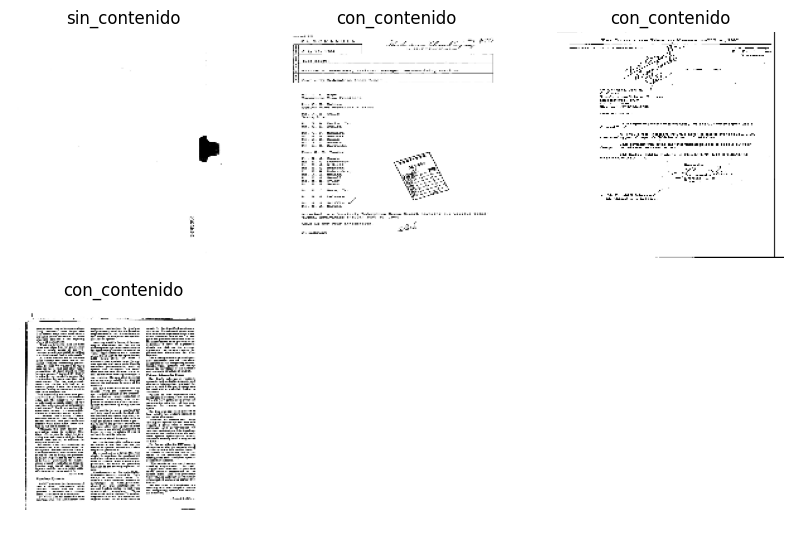

2024-07-18 16:09:16.741847: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [8]:
### Se normalizan los datos
normalization_layer = layers.Rescaling(1./255)

In [9]:
### Se aplica la normalización a los datos
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
### Se define el modelo

# Número de clases en el dataset
num_classes = len(class_names)

# Creación del modelo secuencial
model = Sequential([

  # Capa de reescalado para normalizar los valores de los píxeles entre 0 y 1
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Primera capa convolucional con 32 filtros y un kernel de 3x3, usando padding 'same' para mantener el tamaño de la imagen
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # Primera capa de MaxPooling para reducir la dimensionalidad
  layers.MaxPooling2D(),

  # Segunda capa convolucional con 128 filtros y un kernel de 3x3, usando padding 'same' para mantener el tamaño de la imagen
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  # Segunda capa de MaxPooling para reducir aún más la dimensionalidad
  layers.MaxPooling2D(),
  
  # Capa para aplanar el tensor de salida y convertirlo en un vector
  layers.Flatten(),

  # Capa densa con 256 neuronas y función de activación relu
  layers.Dense(256, activation='relu'),
  # Capa de Dropout para reducir el overfitting durante el entrenamiento, descartando el 20% de las neuronas
  layers.Dropout(0.2),
  # Capa de salida con una neurona por clase, usando la función de activación sigmoid para clasificación binaria o multiclase con etiquetas independientes
  layers.Dense(num_classes, activation='sigmoid')
])

/home/luvanpc/anaconda3/envs/classi/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
### Se compila el modelo

# Se configura el modelo para el entrenamiento.
# Se utiliza el optimizador 'adam' por su eficiencia en la mayoría de los casos.
model.compile(optimizer='adam', 
              # Se usa la pérdida de Entropía Cruzada Categórica Esparsa, adecuada para clasificación multiclase
              # cuando las etiquetas son enteros. 'from_logits=True' indica que las predicciones del modelo
              # son logits y no probabilidades normalizadas.
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # Se mide la 'accuracy' (precisión) para evaluar el rendimiento del modelo durante el entrenamiento y las pruebas.
              metrics=['accuracy'])

In [12]:
# Se establece el número de épocas para el entrenamiento
epochs=10

# Se inicia el entrenamiento del modelo
# train_ds: Dataset de entrenamiento
# validation_data: Dataset de validación para evaluar el modelo en cada época
# epochs: Número total de épocas de entrenamiento
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/home/luvanpc/anaconda3/envs/classi/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1721336957.514226   25509 service.cc:146] XLA service 0x728a7c004c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721336957.514247   25509 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-18 16:09:17.532276: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 16:09:17.623140: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 36/159 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5774 - loss: 10.7214

I0000 00:00:1721336958.807827   25509 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7617 - loss: 4.0545 - val_accuracy: 0.9684 - val_loss: 0.0825
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9943 - loss: 0.0226 - val_accuracy: 0.9684 - val_loss: 0.0881
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9763 - loss: 0.0619 - val_accuracy: 0.9557 - val_loss: 0.1462
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9875 - loss: 0.0486 - val_accuracy: 0.9494 - val_loss: 0.2313
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9645 - loss: 0.2570 - val_accuracy: 0.9304 - val_loss: 0.2670
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9931 - loss: 0.0671 - val_accuracy: 0.9557 - val_loss: 0.2498
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9684 - val_loss: 0.2631
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9999 - loss: 1.4651e-04 - val_accuracy: 0.9557 -

### aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

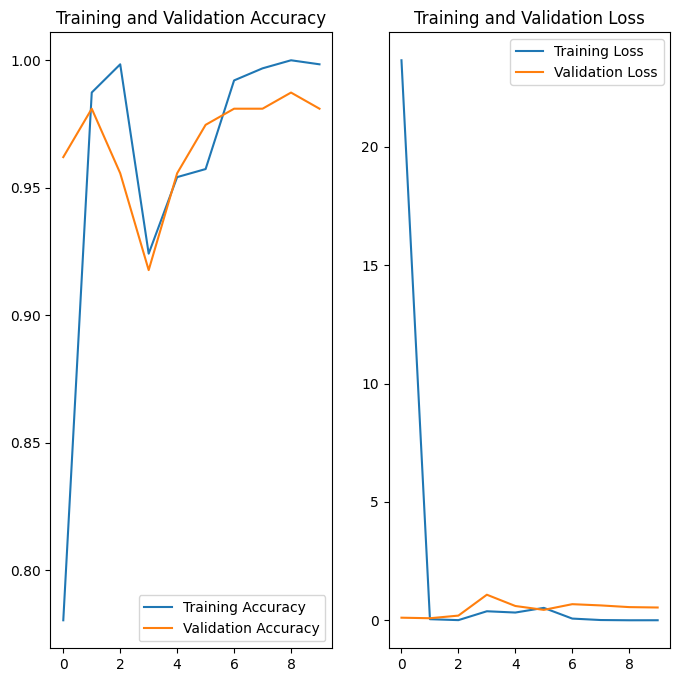

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']  
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import os

lista_true = []

con_contenido = "data_test/docs_con_contenido"

for dirpath, dirnames, filenames in os.walk(con_contenido):
    for file in filenames:
        lista_true.append('con_contenido')

sin_contenido = "data_test/docs_sin_contenido"

for dirpath, dirnames, filenames in os.walk(sin_contenido):
    for file in filenames:
        lista_true.append('sin_contenido')

In [ ]:
lista_true

['con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_cont

In [ ]:
image_size = img_height

In [ ]:
folder_path = "data_test/docs_con_contenido"

In [ ]:
lista_predict = []

In [ ]:
for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.abspath(os.path.join(dirpath, file))

            img = tf.keras.utils.load_img(file_path, target_size=(image_size, image_size))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)
            
            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            lista_predict.append(class_names[np.argmax(score)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━

In [ ]:
folder_path = "data_test/docs_sin_contenido"

In [ ]:
for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.abspath(os.path.join(dirpath, file))

            img = tf.keras.utils.load_img(file_path, target_size=(image_size, image_size))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)
            
            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            lista_predict.append(class_names[np.argmax(score)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

In [ ]:
lista_predict

['con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'con_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_contenido',
 'sin_cont

In [ ]:
def precision_modelo(lista_predict, lista_true):

    cont = 0

    for i in range(len(lista_predict)):
        
        if (lista_predict[i]==lista_true[i]):
            cont += 1
            
    precision = (cont/len(lista_predict))*100

    return precision

In [ ]:
precision_modelo(lista_predict, lista_true)

100.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import numpy as np
from matplotlib import pyplot as plt
import json
import os
import cv2
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import f1_score


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Predicción del modelo')
    plt.show()

In [ ]:
class_names

['con_contenido', 'sin_contenido']

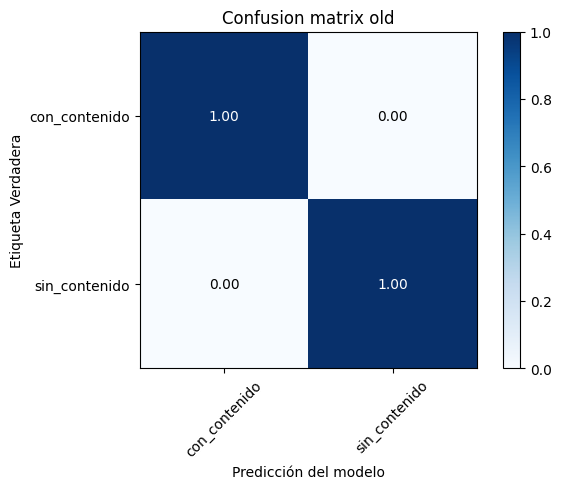

In [ ]:
plot_confusion_matrix(lista_true, lista_predict, class_names, normalize=True, title='Confusion matrix old')

In [ ]:
f1_score(lista_true, lista_predict, labels=class_names, average='weighted')

1.0

In [ ]:
img = tf.keras.utils.load_img("bog_iq051008787518-page-002.png", target_size=(image_size, image_size))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

FileNotFoundError: [Errno 2] No such file or directory: 'bog_iq051008787518-page-002.png'

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)